In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")

In [14]:
csv_file_path = "../data/Augmented_Fraud_Dataset_Final_Updated.csv"

df_raw = pd.read_csv(csv_file_path)
print("Raw Data Shape:", df_raw.shape)
print(df_raw.head())

Raw Data Shape: (14776, 24)
   Dummy Policy No  ASSURED_AGE NOMINEE_RELATION  OCCUPATION  \
0      1159.951989    29.860396           Sister     Service   
1       761.927121    36.000000              Son     Service   
2       950.204841    62.107053           Spouse     Retired   
3      1012.041512    53.552922             Wife  Profession   
4      1292.570925    49.337484          Husband   Housewife   

  POLICY SUMASSURED      Premium PREMIUMPAYMENTMODE Annual Income  \
0       3349340.128  417223.2177             Yearly   972309.7517   
1            491939        45969             Yearly       1541742   
2      -129047.0001  203172.0451             Yearly   708014.4195   
3       1035557.725  109874.8143             Yearly   -2293613.74   
4        463708.001  62432.50639             Yearly   206621.5492   

  HOLDERMARITALSTATUS INDIV_REQUIREMENTFLAG  ...  CORRESPONDENCEPOSTCODE  \
0              Single           Non Medical  ...                  700050   
1            divorce

In [15]:
def clean_data(df):
    """Clean data using a similar pattern to your existing code."""
    df_cleaned = df.drop(columns=["Dummy Policy No", "Bank code"], errors="ignore")
    
    # Convert date columns to datetime
    date_columns = ["POLICYRISKCOMMENCEMENTDATE", "Date of Death", "INTIMATIONDATE"]
    for col in date_columns:
        if col in df_cleaned.columns:
            df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors="coerce")

    numeric_cols = ["POLICY SUMASSURED", "Premium", "Annual Income"]
    for col in numeric_cols:
        df_cleaned[col] = (
            df_cleaned[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.strip()
        )
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors="coerce")
    
    # Derived features 
    if "Date of Death" in df_cleaned.columns and "POLICYRISKCOMMENCEMENTDATE" in df_cleaned.columns:
        df_cleaned["Policy Tenure (Days)"] = (
            df_cleaned["Date of Death"] - df_cleaned["POLICYRISKCOMMENCEMENTDATE"]
        ).dt.days
    if "INTIMATIONDATE" in df_cleaned.columns and "Date of Death" in df_cleaned.columns:
        df_cleaned["Claim Intimation Lag (Days)"] = (
            df_cleaned["INTIMATIONDATE"] - df_cleaned["Date of Death"]
        ).dt.days
    
    if "POLICY SUMASSURED" in df_cleaned.columns:
        df_cleaned["POLICY SUMASSURED"] = df_cleaned["POLICY SUMASSURED"].replace(0, np.nan)
    
    # Ratio features
    if "Premium" in df_cleaned.columns and "POLICY SUMASSURED" in df_cleaned.columns:
        df_cleaned["Premium-to-Sum Assured Ratio"] = (
            df_cleaned["Premium"] / df_cleaned["POLICY SUMASSURED"]
        )
        df_cleaned["Income-to-Sum Assured Ratio"] = (
            df_cleaned["Annual Income"] / df_cleaned["POLICY SUMASSURED"]
        )
    
    df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_cleaned.dropna(
        subset=["Premium-to-Sum Assured Ratio", "Income-to-Sum Assured Ratio"], 
        inplace=True
    )
    
    cat_cols = ["NOMINEE_RELATION", "OCCUPATION", "PREMIUMPAYMENTMODE",
                "HOLDERMARITALSTATUS", "CHANNEL", "Product Type"]
    df_cleaned = pd.get_dummies(df_cleaned, columns=cat_cols, drop_first=True)
    
    df_cleaned["Fraud_Type"] = df_cleaned["Fraud Category"].fillna("No Fraud")
    df_cleaned["Fraudulent"] = 1
    df_cleaned.drop(columns=["Fraud Category", "STATUS", "SUB_STATUS"], inplace=True, errors="ignore")
    
    df_cleaned.drop(columns=date_columns, inplace=True, errors="ignore")
    
    return df_cleaned

df_cleaned = clean_data(df_raw)
print("\nCleaned data shape:", df_cleaned.shape)
print(df_cleaned.head())


Cleaned data shape: (14033, 51)
   ASSURED_AGE  POLICY SUMASSURED       Premium  Annual Income  \
0    29.860396       3.349340e+06  417223.21770   9.723098e+05   
1    36.000000       4.919390e+05   45969.00000   1.541742e+06   
2    62.107053      -1.290470e+05  203172.04510   7.080144e+05   
3    53.552922       1.035558e+06  109874.81430  -2.293614e+06   
4    49.337484       4.637080e+05   62432.50639   2.066215e+05   

  INDIV_REQUIREMENTFLAG  Policy Term  Policy Payment Term CORRESPONDENCECITY  \
0           Non Medical    15.712919             9.866811           Calcutta   
1           Non Medical    30.000000            20.000000              GODDA   
2           Non Medical    14.521743             9.996692            BHIWANI   
3           Non Medical    12.422285             9.890028             Kanpur   
4               Medical    15.417569             9.986136             Badaun   

  CORRESPONDENCESTATE CORRESPONDENCEPOSTCODE  ...  \
0         West Bengal               


----- DATA OVERVIEW -----
Shape: (14033, 51)

Head:
    ASSURED_AGE  POLICY SUMASSURED       Premium  Annual Income  \
0    29.860396       3.349340e+06  417223.21770   9.723098e+05   
1    36.000000       4.919390e+05   45969.00000   1.541742e+06   
2    62.107053      -1.290470e+05  203172.04510   7.080144e+05   
3    53.552922       1.035558e+06  109874.81430  -2.293614e+06   
4    49.337484       4.637080e+05   62432.50639   2.066215e+05   

  INDIV_REQUIREMENTFLAG  Policy Term  Policy Payment Term CORRESPONDENCECITY  \
0           Non Medical    15.712919             9.866811           Calcutta   
1           Non Medical    30.000000            20.000000              GODDA   
2           Non Medical    14.521743             9.996692            BHIWANI   
3           Non Medical    12.422285             9.890028             Kanpur   
4               Medical    15.417569             9.986136             Badaun   

  CORRESPONDENCESTATE CORRESPONDENCEPOSTCODE  ...  \
0         West 

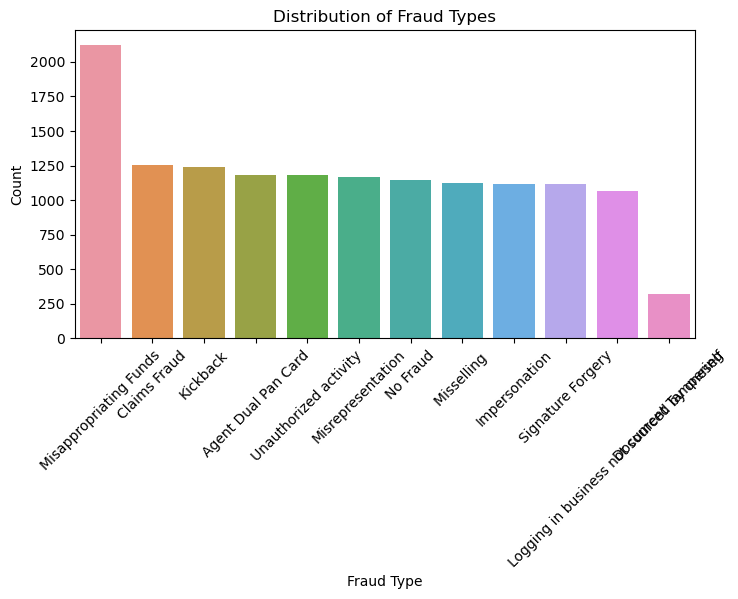

In [16]:
def perform_eda(df):
    print("\n----- DATA OVERVIEW -----")
    print("Shape:", df.shape)
    print("\nHead:\n", df.head())
    print("\nData Types:\n", df.dtypes)
    print("\nSummary Statistics:\n", df.describe())
    
    missing = df.isnull().sum()
    print("\nMissing Values in Cleaned Data:\n", missing[missing > 0])
    
    # plt.figure(figsize=(6,4))
    # sns.countplot(x='Fraudulent', data=df)
    # plt.title("Distribution of Fraudulent Claims (Binary)")
    # plt.xlabel("Fraudulent (0 = No, 1 = Yes)")
    # plt.ylabel("Count")
    # plt.show()
    
    # Distribution of Fraud Types
    plt.figure(figsize=(8,4))
    order = df['Fraud_Type'].value_counts().index
    sns.countplot(data=df, x='Fraud_Type', order=order)
    plt.title("Distribution of Fraud Types")
    plt.xlabel("Fraud Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
    
    # Correlation heatmap
#     num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     plt.figure(figsize=(12,10))
#     sns.heatmap(df[num_cols].corr(), annot=False, cmap="coolwarm")
#     plt.title("Correlation Heatmap")
#     plt.show()

perform_eda(df_cleaned)

df_cleaned shape before building graph: (14033, 51)
Number of nodes in G_expanded_optimized: 14483
Number of edges in G_expanded_optimized: 120546
Number of connected components: 1
Largest ring size: 14483
Selected local original nodes (up to 20): [25, 41, 51, 56, 70, 73, 78, 164, 196, 201, 203, 222, 240, 243, 244, 263, 288, 293, 302, 349]
Total selected local original nodes: 20
Sum of Fraudulent values: 20
Calculated local fraud ratio: 1.0
Prediction for new record: Fraudulent


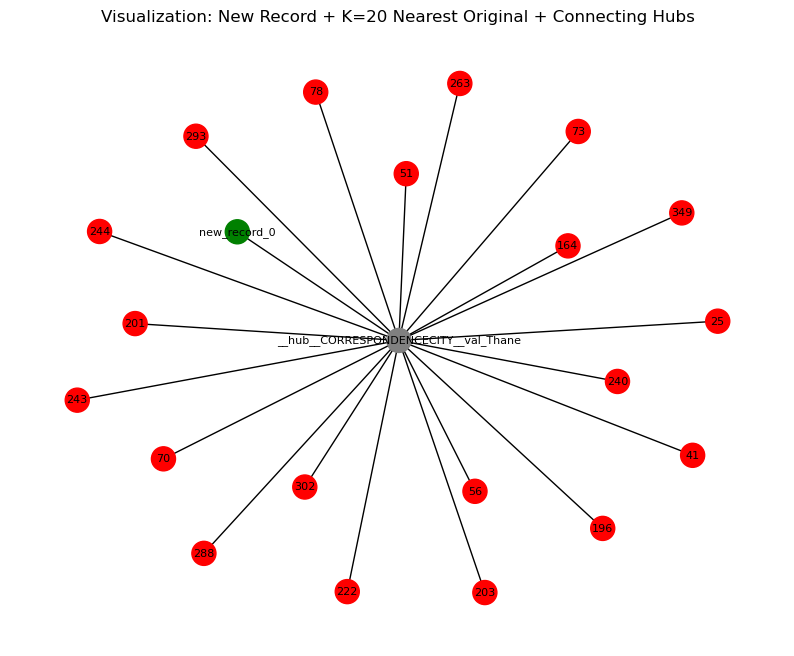

In [17]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def bin_numeric_column(series, bin_size=30):
    """
    Bins a numeric column into intervals of 'bin_size'.
    Negative/NaN => special bin.
    """
    binned = []
    for val in series:
        if pd.isna(val):
            binned.append("NaN_bin")
        else:
            bin_index = int(val // bin_size)
            binned.append(f"bin_{bin_index}")
    return pd.Series(binned, index=series.index)

def build_fraud_ring_graph_expanded_optimized(df):
    """
    Uses a hub-node approach to build a fraud ring graph. Each record is a node.
    For each attribute (city, state, dummy features, and binned numeric features), 
    a hub node is created so that records sharing the same attribute value 
    are indirectly connected via that hub.
    """

    if "Policy Tenure (Days)" in df.columns:
        df["Tenure_Bin"] = bin_numeric_column(df["Policy Tenure (Days)"], bin_size=30)
    else:
        df["Tenure_Bin"] = "N/A"

    if "Claim Intimation Lag (Days)" in df.columns:
        df["Intimation_Bin"] = bin_numeric_column(df["Claim Intimation Lag (Days)"], bin_size=30)
    else:
        df["Intimation_Bin"] = "N/A"

    G = nx.Graph()

    for idx, row in df.iterrows():
        # Here we assume df has "Fraudulent" as 0/1. 
        fraudulent_label = row.get("Fraudulent", 0)
        
        G.add_node(
            idx,
            Fraud_Type=row.get("Fraud_Type", "Unknown"),
            Fraudulent=fraudulent_label,
            city=row.get("CORRESPONDENCECITY", ""),
            state=row.get("CORRESPONDENCESTATE", "")
        )

    # list of link attributes
    link_attrs = []
    if "CORRESPONDENCECITY" in df.columns:
        link_attrs.append("CORRESPONDENCECITY")
    if "CORRESPONDENCESTATE" in df.columns:
        link_attrs.append("CORRESPONDENCESTATE")

    for col in df.columns:
        if col.startswith("OCCUPATION_"):
            link_attrs.append(col)
        elif col.startswith("NOMINEE_RELATION_"):
            link_attrs.append(col)
        elif col.startswith("HOLDERMARITALSTATUS_"):
            link_attrs.append(col)
        elif col.startswith("Product Type_"):
            link_attrs.append(col)
        elif col.startswith("PREMIUMPAYMENTMODE_"):
            link_attrs.append(col)
        elif col.startswith("CHANNEL_"):
            link_attrs.append(col)
    
    if "Tenure_Bin" in df.columns:
        link_attrs.append("Tenure_Bin")
    if "Intimation_Bin" in df.columns:
        link_attrs.append("Intimation_Bin")

    # hub nodes and add edges
    for attr in link_attrs:
        if (df[attr].dtype == bool) or (df[attr].dtype == np.uint8) or (df[attr].dtype == np.int64):
            ones_indices = df.index[df[attr] == 1].tolist()
            if ones_indices:
                hub_name = f"__hub__{attr}"
                G.add_node(hub_name, hub_type=attr, is_hub=True)
                for row_id in ones_indices:
                    G.add_edge(row_id, hub_name, reason=attr)
        else:
            # For categorical-like attributes (including binned numeric)
            groups = df.groupby(attr).groups
            for val, idx_list in groups.items():
                hub_name = f"__hub__{attr}__val_{val}"
                G.add_node(hub_name, hub_type=attr, attr_value=val, is_hub=True)
                for row_id in idx_list:
                    G.add_edge(row_id, hub_name, reason=attr)

    return G


if __name__ == "__main__":
    # Step 1: Build the graph
    print("df_cleaned shape before building graph:", df_cleaned.shape)
    G_expanded_optimized = build_fraud_ring_graph_expanded_optimized(df_cleaned)
    print("Number of nodes in G_expanded_optimized:", G_expanded_optimized.number_of_nodes())
    print("Number of edges in G_expanded_optimized:", G_expanded_optimized.number_of_edges())
    print("Number of connected components:", nx.number_connected_components(G_expanded_optimized))
    largest_comp = max(nx.connected_components(G_expanded_optimized), key=len)
    print("Largest ring size:", len(largest_comp))
    
    # Step 2: Define and add a new record
    new_record = {
        "ASSURED_AGE": 51.39709319,
        "NOMINEE_RELATION_Husband": 1,
        "OCCUPATION_Service": 1,
        "POLICY SUMASSURED": 81954.81458,
        "Premium": 94143.42024,
        "PREMIUMPAYMENTMODE_Yearly": 1,
        "Annual Income": 3323731.007,
        "HOLDERMARITALSTATUS_Married": 1,
        "INDIV_REQUIREMENTFLAG_Non Medical": 1,
        "Policy Term": 15.03808575,
        "Policy Payment Term": 9.918994057,
        "CORRESPONDENCECITY": "Thane",
        "CORRESPONDENCESTATE": "Maharashtra",
        "Product Type_ULIP": 1,
        "CHANNEL_Retail Agency": 1
    }
    df_new = pd.DataFrame([new_record])

    # Bin numeric columns if needed
    if "Policy Tenure (Days)" in df_new.columns:
        df_new["Tenure_Bin"] = bin_numeric_column(df_new["Policy Tenure (Days)"], bin_size=30)
    else:
        df_new["Tenure_Bin"] = "N/A"
    if "Claim Intimation Lag (Days)" in df_new.columns:
        df_new["Intimation_Bin"] = bin_numeric_column(df_new["Claim Intimation Lag (Days)"], bin_size=30)
    else:
        df_new["Intimation_Bin"] = "N/A"
    
    new_node_id = "new_record_0"
    G_expanded_optimized.add_node(
        new_node_id,
        Fraud_Type="Unknown",
        Fraudulent=None,  # Unknown
        city=df_new.loc[0, "CORRESPONDENCECITY"],
        state=df_new.loc[0, "CORRESPONDENCESTATE"]
    )
    
    # Link the new record to relevant hubs
    link_attrs = []
    if "CORRESPONDENCECITY" in df_new.columns:
        link_attrs.append("CORRESPONDENCECITY")
    if "CORRESPONDENCESTATE" in df_new.columns:
        link_attrs.append("CORRESPONDENCESTATE")
    for col in df_new.columns:
        if col.startswith("OCCUPATION_"):
            link_attrs.append(col)
        elif col.startswith("NOMINEE_RELATION_"):
            link_attrs.append(col)
        elif col.startswith("HOLDERMARITALSTATUS_"):
            link_attrs.append(col)
        elif col.startswith("Product Type_"):
            link_attrs.append(col)
        elif col.startswith("PREMIUMPAYMENTMODE_"):
            link_attrs.append(col)
        elif col.startswith("CHANNEL_"):
            link_attrs.append(col)
    if "Tenure_Bin" in df_new.columns:
        link_attrs.append("Tenure_Bin")
    if "Intimation_Bin" in df_new.columns:
        link_attrs.append("Intimation_Bin")

    for attr in link_attrs:
        val = df_new.loc[0, attr]
        # For dummy attributes
        if (
            attr.startswith("OCCUPATION_")
            or attr.startswith("NOMINEE_RELATION_")
            or attr.startswith("HOLDERMARITALSTATUS_")
            or attr.startswith("Product Type_")
            or attr.startswith("PREMIUMPAYMENTMODE_")
            or attr.startswith("CHANNEL_")
        ):
            hub_name = f"__hub__{attr}"
        else:
            # For normal or binned attributes
            hub_name = f"__hub__{attr}__val_{val}"
        
        if not G_expanded_optimized.has_node(hub_name):
      
            if (
                attr.startswith("OCCUPATION_")
                or attr.startswith("NOMINEE_RELATION_")
                or attr.startswith("HOLDERMARITALSTATUS_")
                or attr.startswith("Product Type_")
                or attr.startswith("PREMIUMPAYMENTMODE_")
                or attr.startswith("CHANNEL_")
            ):
                G_expanded_optimized.add_node(hub_name, hub_type=attr, is_hub=True)
            else:
                G_expanded_optimized.add_node(hub_name, hub_type=attr, attr_value=val, is_hub=True)
        
        G_expanded_optimized.add_edge(new_node_id, hub_name, reason=attr)
    
    # local fraud ratio (up to 20 nearest original nodes)
    all_dists = nx.single_source_shortest_path_length(G_expanded_optimized, new_node_id)
    original_nodes = [(node, dist) for node, dist in all_dists.items() if node in df_cleaned.index]
    original_nodes_sorted = sorted(original_nodes, key=lambda x: x[1])
    
    k = 20
    local_original_nodes = [node for node, dist in original_nodes_sorted[:k]]

    total_original = len(local_original_nodes)
    fraud_sum = sum(G_expanded_optimized.nodes[node].get("Fraudulent", 0) for node in local_original_nodes)
    local_fraud_ratio = fraud_sum / total_original if total_original else 0
    
    print("Selected local original nodes (up to 20):", local_original_nodes)
    print("Total selected local original nodes:", total_original)
    print("Sum of Fraudulent values:", fraud_sum)
    print("Calculated local fraud ratio:", local_fraud_ratio)
    
    threshold = 0.85
    prediction = "Fraudulent" if local_fraud_ratio >= threshold else "Non-Fraudulent"
    print("Prediction for new record:", prediction)

    # Visualization
    sub_nodes = set([new_node_id]) 
    for node, dist in original_nodes_sorted[:k]:
        path_nodes = nx.shortest_path(G_expanded_optimized, new_node_id, node)
        sub_nodes.update(path_nodes)

    SG = G_expanded_optimized.subgraph(sub_nodes).copy()

    pos = nx.spring_layout(SG, seed=42)  # or nx.kamada_kawai_layout(SG)

    node_colors = []
    for n in SG.nodes():
        n_data = SG.nodes[n]
        if n == new_node_id:
         
            node_colors.append("green")
        elif n_data.get("is_hub", False):
            # Hub node => color gray
            node_colors.append("gray")
        else:
           
            fraud_val = n_data.get("Fraudulent", 0)
            if fraud_val == 1:
                node_colors.append("red")   # fraudulent
            else:
                node_colors.append("blue")  # non-fraudulent

  
    plt.figure(figsize=(10, 8))
    nx.draw_networkx(
        SG,
        pos,
        node_color=node_colors,
        with_labels=True,
        font_size=8
    )
    plt.title("Visualization: New Record + K=20 Nearest Original + Connecting Hubs")
    plt.axis("off")
    plt.show()
